In [70]:
import os
import pandas as pd
from collections import Counter
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [71]:
os.chdir('/Volumes/AHN/captive_ape_microbiome')
%run scripts/analyses/functions.ipynb

In [72]:
INDIR = 'results/16s/inputs'
metadata_file = f'{INDIR}/16S_metadata.txt'
tax_table_file = f'{INDIR}/ASVs_taxonomy.txt'
asv_table_file = f'{INDIR}/ASV_tab.txt'
OUTDIR = 'results/16s/analyses'
%Rpush INDIR
%Rpush OUTDIR
!mkdir $OUTDIR/tables
!mkdir $OUTDIR/figures
!mkdir $OUTDIR/intermediate_output

mkdir: results/16s/analyses/tables: File exists
mkdir: results/16s/analyses/figures: File exists
mkdir: results/16s/analyses/intermediate_output: File exists


#### designate 16-ASVs as host-restricted, mixed host, or unique to captive

In [73]:
asv_16s = asv_hr_table(asv_table_file,metadata_file,tax_table_file)
print(len(asv_16s),'total 16S ASVs')
asv_16s_captive = asv_16s[asv_16s['CP_pres']==True]
print(len(asv_16s_captive),'16S ASVs found in captive apes')
print(asv_16s_captive['HR_type'].value_counts())
asv_16s.to_csv(f'{OUTDIR}/tables/16S_ASVs_summary.txt',sep='\t',index=None)

1977 total 16S ASVs
871 16S ASVs found in captive apes
HR_human                    227
MX_human_single_wild_ape    187
MX_4_hominids               166
MX_human_2_wild_apes        128
Unique_CP                   106
MX_2_wild_apes               20
MX_3_wild_apes               19
HR_wild_chimp                10
HR_wild_gorilla               8
Name: HR_type, dtype: int64


#### Determine distribution of captive associated 16-ASVs across host species and locations

In [19]:
def multi_site_sp(cp_desc):
    """Takes in a list of sample site_Descriptions and designate ASVs 
    based on whether they are found across multiple locations or 
    a single location, observed in a single host species or multiple 
    host species"""
    sites = list(set([x.split('_')[0] for x in cp_desc]))
    sitesNum = len(sites)
    sitesMulti = 'multi_site' if sitesNum > 1 else 'single_site'      
    species = list(set([x.split('_')[2] for x in cp_desc]))
    speciesNum = len(species)
    speciessMulti = 'multi_sp' if speciesNum > 1 else 'single_sp' 
    return(sitesMulti + '_' + speciessMulti)

#multi_site_sp(['HOUZ_captive_chimp','HOUZ_captive_gorilla'])

def captive_apes_asv_summary(asv_hr_table_output,metadata_file):
    """summarizes captive 16-ASVs based on distribution across host species, sites, enclosures"""
    asv_cp = asv_hr_table_output[asv_hr_table_output['CP_pres']==True] #subset to captive ASVs
    metadata = pd.read_csv(metadata_file,sep='\t',index_col=None)
    metadata['Description_site'] = metadata['site_code']+'_'+metadata['Description']
    sample_type_site_dict = dict(zip(metadata['X.SampleID'], metadata['Description_site']))
    description_df = asv_cp['sampleNames'].apply(lambda l: pd.Series(
        [sample_type_site_dict[name] for name in l]).value_counts()) 
    #table where rows are ASVs, columns are description and locations of samples, 
    #and values are sample counts
    description_df = description_df.fillna(0)  
    #print(description_df.head()) 
    #identify which Description_site columns belong to captive apes
    capt_desc = list(set(metadata['Description_site'][metadata['captivity_status']=='captive'])) 
    description_df = description_df[capt_desc]
    description_df['CP_sp_loc'] = description_df.apply(lambda row: list(row.index[row>0]),axis=1)
    description_df['numEnclosure'] = description_df['CP_sp_loc'].apply(lambda x: len(x))
    description_df['multi_site_sp'] = description_df['CP_sp_loc'].apply(lambda x:  
                                                                        multi_site_sp(x))
    #print(description_df[['CP_sp_loc','numEnclosure','multi_site_sp']].head())
    asv_cp_table = asv_cp.merge(description_df,left_index=True,right_index=True)
    return(asv_cp_table)


In [20]:
asv_cp_table = captive_apes_asv_summary(asv_16s,metadata_file)
asv_cp_table.to_csv(f'{OUTDIR}/intermediate_output/16S_captive_Figure1A_data.txt',sep='\t',index=None)
#print(asv_cp_table.head())
asv_cp_table_summary = asv_cp_table.groupby(['multi_site_sp']).size().reset_index(name="count")
print(asv_cp_table_summary)

           multi_site_sp  count
0    multi_site_multi_sp    633
1   multi_site_single_sp     40
2   single_site_multi_sp     30
3  single_site_single_sp    168


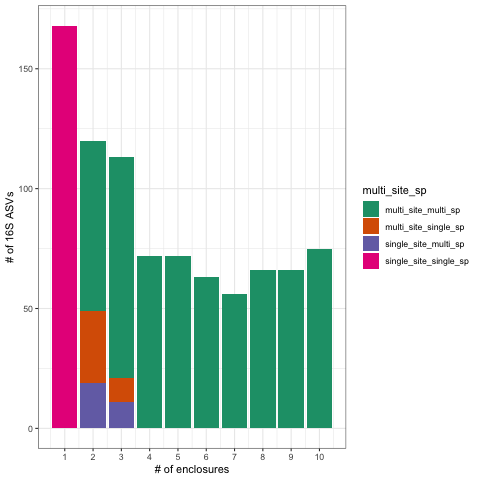

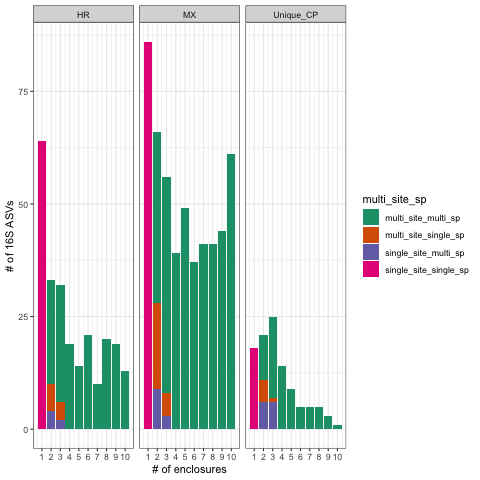

In [21]:
%%R 
library(tidyverse)
library(cowplot)

table_file <- paste0(OUTDIR,'/intermediate_output/16S_captive_Figure1A_data.txt')
Figure1A_data = read.table(table_file,header=TRUE,sep='\t')

#Figure 1A
Figure1A_plot <- ggplot(Figure1A_data, aes(numEnclosure,fill=multi_site_sp)) +
  geom_bar() + 
  ylab('# of 16S ASVs')+
  xlab('# of enclosures')+
  theme_bw()+
  scale_fill_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'))+
  scale_x_continuous(breaks= c(1,2,3,4,5,6,7,8,9,10))
print(Figure1A_plot)
ggsave(Figure1A_plot,height=4,width=6,file = file.path(paste0(OUTDIR,'/figures/Fig_distributionASVs.pdf')))


Figure1A_facet_by_HRcat <- ggplot(Figure1A_data, aes(numEnclosure,fill=multi_site_sp)) +
    geom_bar() + 
    ylab('# of 16S ASVs')+
    xlab('# of enclosures')+
    theme_bw()+
    scale_fill_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'))+
    scale_x_continuous(breaks= c(1,2,3,4,5,6,7,8,9,10))+
    facet_wrap(~HR_cat)
ggsave(Figure1A_facet_by_HRcat,height=4,width=6, file = file.path(paste0(OUTDIR,'/figures/Fig_distributionASVs_HRcat.pdf')))
print(Figure1A_facet_by_HRcat)

#### Determine proportion of shared ASVs (Figure 1B)

In [22]:
from itertools import combinations

def add_tax_to_asv_table(asv_table_file,tax_table_file):
    """adds taxonomic information to the last few columns of the ASV table"""
    asv_table = pd.read_csv(asv_table_file,sep='\t',index_col=0)
    asv_table = asv_table.reset_index().rename(columns={"index": "ASV"})
    tax_table = pd.read_csv(tax_table_file,sep='\t',index_col=None)
    asv_table_tax = asv_table.merge(tax_table[['ASV','Phylum','Order','Family','Genus']],on='ASV',how='left')
    #print(len(asv_table_tax),'total ASVs')
    asv_table_tax = asv_table_tax[~asv_table_tax['Genus'].isna()]
    #print(len(asv_table_tax),'total ASVs assigned to Genus level taxonomy')
    return(asv_table_tax)
#asv_table_tax = add_tax_to_asv_table(asv_table_file,tax_table_file)
#print(asv_table_tax.head())

def pw_metadata_capt_samples(metadata_file):
    """generate all pairwise comparisons between two individuals with host species and site metadata"""
    metadata = pd.read_csv(metadata_file,sep='\t',index_col=None)
    metadata['Description_site'] = metadata['site_code']+'_'+metadata['Description']
    sample_type_site_dict = dict(zip(metadata['X.SampleID'], metadata['Description_site']))

    cp_samples = metadata['X.SampleID'][metadata['captivity_status']=='captive'] #subset to just captive samples
    pw_df = pd.DataFrame(combinations(cp_samples, 2),columns=['ind1','ind2'])
    pw_df['desc_site_ind1'] = pw_df['ind1'].apply(lambda x:sample_type_site_dict[x])
    pw_df['desc_site_ind2'] = pw_df['ind2'].apply(lambda x:sample_type_site_dict[x])
    pw_df['full_desc_comp'] = pw_df['desc_site_ind1'] + '_vs_' + pw_df['desc_site_ind2']
    pw_df['sp_site_comp'] = pw_df.apply(lambda row: 
                                        get_sp_site_comp(row['desc_site_ind1'],row['desc_site_ind2']),
                                        axis=1)
    return(pw_df)
#pw_df = pw_metadata_capt_samples(metadata_file)
#print(pw_df.head())

def get_sp_site_comp(ind1,ind2):
    """determines if any two samples belongs to the same host species or location"""
    sp = ('same_spec' if ind1.split('_')[2] == ind2.split('_')[2] else 'diff_spec')
    st = ('same_site' if ind1.split('_')[0] == ind2.split('_')[0] else 'diff_site')
    return(sp+'_'+st)
#get_sp_site_comp('COLZ_captive_bonobo','COLZ_captive_chimp')

def shared_ASVs_common_gen(ind1,ind2,asv_table_tax):
    "calculate shared genera and ASVs between any two samples" 
    #subset asv_tax_table to two samples and only asv they harbors
    pw = asv_table_tax[['Phylum','Order','Family','Genus','ASV',ind1,ind2]][
        (asv_table_tax[ind1]>0)|(asv_table_tax[ind2]>0)]  
    #determine genera shared b/n two samples
    common_gen = list(
                 set(pw[pw[ind1]>0]['Genus']) & 
                 set(pw[pw[ind2]>0]['Genus'])) #determine genera shared in common
    len_common_gen = len(common_gen)
    pw_common =pw[pw['Genus'].isin(common_gen)] #subset asv_tax_table to common genera
    ind1_ASVs = len(pw_common[(pw_common[ind1]>0)]) #determine #ASVs in common genera in ind1
    ind2_ASVs = len(pw_common[(pw_common[ind2]>0)])  #determine #ASV in common genera ind2
    if len_common_gen == 0:
        common_ASVs = 0
        prop_shared = 'nan' #pairwise comparison has no genera in common   
    else:     
        common_ASVs = len(pw_common[(pw_common[ind1]>0)&(pw_common[ind2]>0)])#determine shared ASVs 
        prop_shared = common_ASVs/min(ind1_ASVs,ind2_ASVs)
  
    res = pd.Series([ind1,ind2,common_gen,len_common_gen,ind1_ASVs,ind2_ASVs,common_ASVs,prop_shared],
              index=['ind1','ind2','common_gen','len_common_gen',
                     'ind1_ASVs','ind2_ASVs','common_ASVs','prop_shared'])
    return(res)
#shared_ASVs_common_gen('cp.ora.ATLZ.114.16s','cp.ora.ATLZ.115.16s',asv_table_tax)

In [23]:
#generate all pairwise comparisons b/n samples
pw_df = pw_metadata_capt_samples(metadata_file)
#add taxonomy info to asv table
asv_table_tax = add_tax_to_asv_table(asv_table_file,tax_table_file)
#calclate proportion of shared ASVs for all pairwise comparisons
shared_ASV_all_genera = pw_df.apply(lambda row: 
                    shared_ASVs_common_gen(row['ind1'],row['ind2'],asv_table_tax),axis=1)
#how many comparisons has no genera in common
no_common_gen = shared_ASV_all_genera[shared_ASV_all_genera['prop_shared'].isna()]
print(len(no_common_gen),'pairwise comparison do not have an shared genera')
#merge with pw metadata
pw_shared_ASV_all_genera = pw_df.merge(shared_ASV_all_genera,on=['ind1','ind2'])                       
pw_shared_ASV_all_genera.to_csv(
    f'{OUTDIR}/intermediate_output/16S_captive_Figure1B_data.txt',
    sep='\t',index=False)

0 pairwise comparison do not have an shared genera


In [24]:
%%R
print('proportion shared - all ASVs')
table_file <- paste0(OUTDIR,'/intermediate_output/16S_captive_Figure1B_data.txt')
Figure1B_data = read.table(table_file,header=TRUE,sep='\t')

Figure1B_plot <- ggplot(Figure1B_data, aes(x=sp_site_comp, y=prop_shared,fill=sp_site_comp)) + 
    geom_violin()+
    theme_bw()+
    scale_fill_manual(values=c('#7fc97f','#beaed4','#fdc086','#ffff99'))+
    ylab('Proportion of shared ASVs')#
#print(Figure1B_plot)
ggsave(Figure1B_plot, file = file.path(paste0(OUTDIR,'/figures/Fig_propsharedASVs.pdf')))
#
print(c('diff_spec_diff_site mean', mean(Figure1B_data$prop_shared[Figure1B_data$sp_site_comp=='diff_spec_diff_site'])))
print(c('diff_spec_same_site mean', mean(Figure1B_data$prop_shared[Figure1B_data$sp_site_comp=='diff_spec_same_site'])))
print(c('same_spec_diff_site', mean(Figure1B_data$prop_shared[Figure1B_data$sp_site_comp=='same_spec_diff_site'])))
print(c('same_spec_same_site',mean(Figure1B_data$prop_shared[Figure1B_data$sp_site_comp=='same_spec_same_site'])))

library(RVAideMemoire)
diff_spec_diff_site <- Figure1B_data$prop_shared[Figure1B_data$sp_site_comp=='diff_spec_diff_site']
diff_spec_same_site <- Figure1B_data$prop_shared[Figure1B_data$sp_site_comp=='diff_spec_same_site']
same_spec_diff_site <- Figure1B_data$prop_shared[Figure1B_data$sp_site_comp=='same_spec_diff_site']
site_comp <- perm.t.test(diff_spec_same_site,diff_spec_diff_site)
spec_comp <- perm.t.test(same_spec_diff_site,diff_spec_diff_site)
pval <- c(site_comp$p.value,spec_comp$p.value)
names(pval) <- c('site_comp','spec_comp')
print(round(p.adjust(pval,method = "fdr",n = length(pval)),3))

#supplemental figures
FigureSX_sharing_bn_enclosures <- Figure1B_data %>% filter(sp_site_comp=='diff_spec_same_site') 
FigureSX_sharing_bn_enclosures_plot <- ggplot(FigureSX_sharing_bn_enclosures, aes(x=full_desc_comp, y=prop_shared,fill=full_desc_comp)) + 
    geom_violin()+
    scale_fill_manual(values=c('orange2','orange2','orange2','green3',
                               'skyblue','skyblue','skyblue'
                               ))+
    theme_bw()+
    ylab('Proportion of shared ASVs')+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggsave(FigureSX_sharing_bn_enclosures_plot, file = file.path(paste0(OUTDIR,'/figures/Fig_propsharedASVs_enclosure.pdf')))

[1] "proportion shared - all ASVs"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "diff_spec_diff_site mean" "0.618488565335135"       
[1] "diff_spec_same_site mean" "0.649444472017828"       
[1] "same_spec_diff_site" "0.629334185308613"  
[1] "same_spec_same_site" "0.755575131069881"  
  |======================================================================| 100%
  |======================================================================| 100%
site_comp spec_comp 
    0.002     0.002 


R[write to console]: Saving 6.67 x 6.67 in image



 #### Determine proportion of shared ASVs by bacterial order (Figure 1C)

In [25]:
print('prominent bacterial orders in captive apes')
print(asv_16s[asv_16s['CP_pres']==True]['Order'].value_counts()[:10].index)

def prop_shared_by_order(order):
    print(order)
    pw_df = pw_metadata_capt_samples(metadata_file)
    asv_table_tax = add_tax_to_asv_table(asv_table_file,tax_table_file)
    asv_table_order = asv_table_tax[asv_table_tax['Order']==order]
    #print(len(asv_table_order),'ASVs assigned to genera in the bacterial order',order)
    shared_ASV_all_genera = pw_df.apply(lambda row: 
                    shared_ASVs_common_gen(row['ind1'],row['ind2'],asv_table_order),axis=1)
    pw_shared_ASV_all_genera = pw_df.merge(shared_ASV_all_genera,on=['ind1','ind2']) 
    pw_shared_ASV_all_genera['order']=order #create col for order so df can be merged
    #print(len(pw_shared_ASV_all_genera),'comparisons total')
    pw_shared_ASV_all_genera = pw_shared_ASV_all_genera[pw_shared_ASV_all_genera['prop_shared']!='nan']
    print(len(pw_shared_ASV_all_genera),'comparisons after removing those with no gen in common')
    return(pw_shared_ASV_all_genera)


Clostridales = prop_shared_by_order('Clostridiales')
Bacteroidales = prop_shared_by_order('Bacteroidales')
Mollicutes_RF39 = prop_shared_by_order('Mollicutes_RF39')
Erysipelotrichales = prop_shared_by_order('Erysipelotrichales')
Spirochaetales = prop_shared_by_order('Spirochaetales')
Gastranaerophilales = prop_shared_by_order('Gastranaerophilales')
Selenomonadales = prop_shared_by_order('Selenomonadales')
Betaproteobacteriales = prop_shared_by_order('Betaproteobacteriales')
Coriobacteriales = prop_shared_by_order('Coriobacteriales')
Lactobacillales = prop_shared_by_order('Lactobacillales')

all_orders = pw_shared_ASV_all_genera
all_orders['order'] = 'all'
all_orders = pd.concat([all_orders,Clostridales,Bacteroidales,Mollicutes_RF39,Erysipelotrichales,
                        Spirochaetales,Gastranaerophilales,Selenomonadales,Betaproteobacteriales,
                        Coriobacteriales,Lactobacillales])
all_orders.to_csv(f'{OUTDIR}/intermediate_output/16S_captive_Figure1C_data.txt',
                        sep='\t',index=False)

prominent bacterial orders in captive apes
Index(['Clostridiales', 'Bacteroidales', 'Mollicutes_RF39', 'Spirochaetales',
       'Erysipelotrichales', 'Gastranaerophilales', 'Selenomonadales',
       'Betaproteobacteriales', 'Coriobacteriales', 'Lactobacillales'],
      dtype='object')
Clostridiales


/usr/local/anaconda3/envs/ete/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


2926 comparisons after removing those with no gen in common
Bacteroidales
2926 comparisons after removing those with no gen in common
Mollicutes_RF39
0 comparisons after removing those with no gen in common
Erysipelotrichales
2924 comparisons after removing those with no gen in common
Spirochaetales
2775 comparisons after removing those with no gen in common
Gastranaerophilales
0 comparisons after removing those with no gen in common
Selenomonadales
2872 comparisons after removing those with no gen in common
Betaproteobacteriales
2145 comparisons after removing those with no gen in common
Coriobacteriales
707 comparisons after removing those with no gen in common
Lactobacillales
880 comparisons after removing those with no gen in common


[1] "all"
[1] "diff_spec_diff_site mean" "0.618488565335135"       
[1] "diff_spec_same_site mean" "0.649444472017828"       
[1] "same_spec_diff_site mean" "0.629334185308613"       
[1] "same_spec_same_site mean" "0.755575131069881"       
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
     site_comp      spec_comp enclosure_comp 
         0.003          0.006          0.003 
[1] "Clostridiales"
[1] "diff_spec_diff_site mean" "0.598068736965273"       
[1] "diff_spec_same_site mean" "0.611471626490708"       
[1] "same_spec_diff_site mean" "0.610574673072604"       
[1] "same_spec_same_site mean" "0.724009405761623"       
  |======================================================================| 100%
  |======================================================================| 100%
  |===========

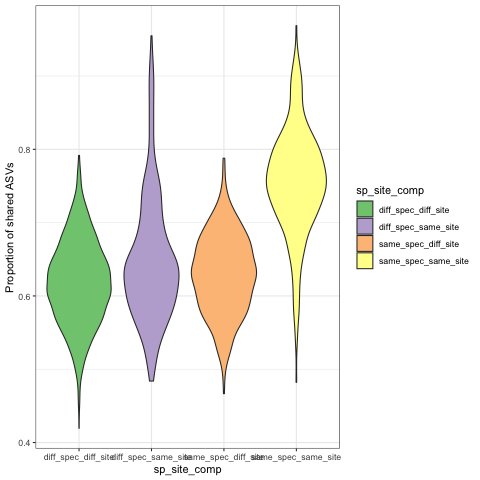

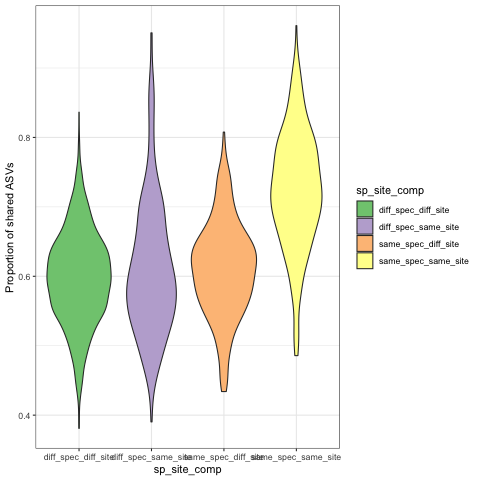

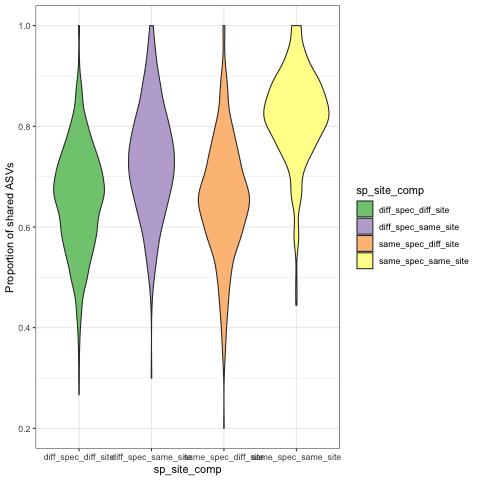

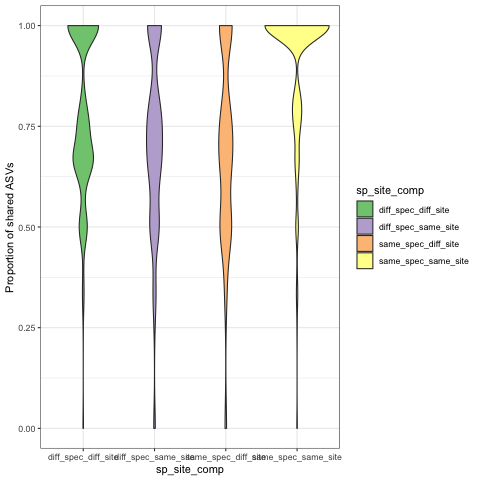

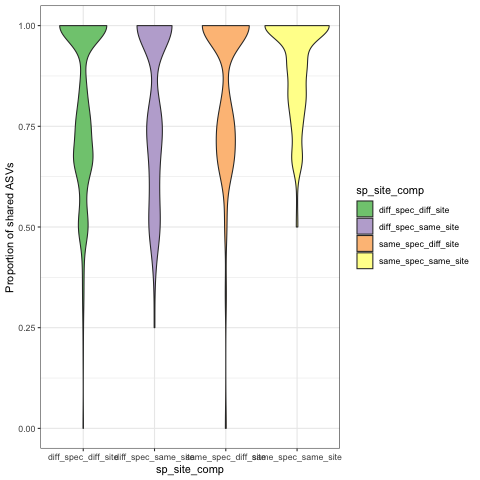

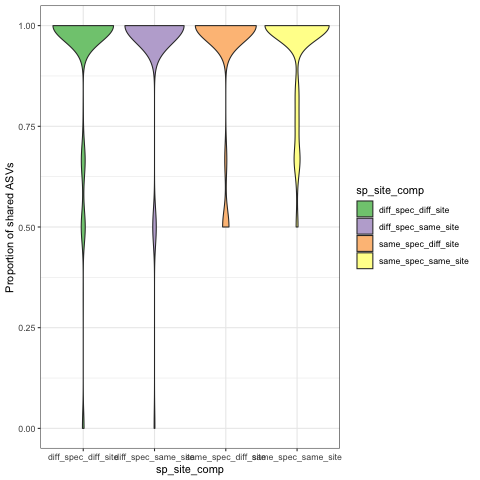

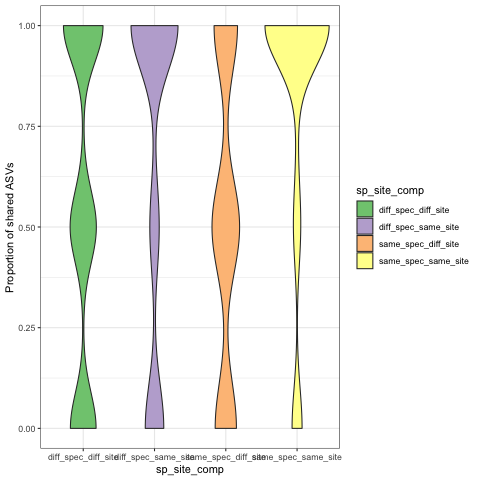

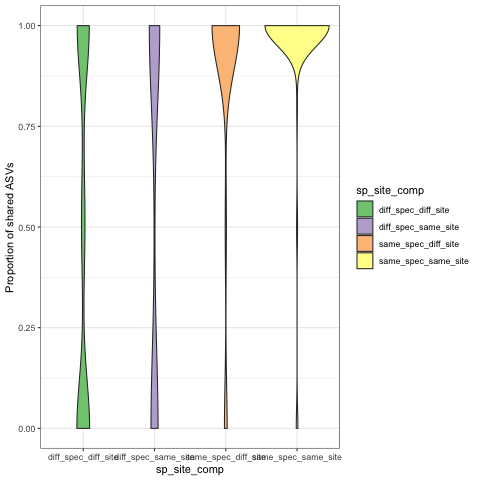

In [67]:
%%R
#see how shared ASVs varies by bacterial order
table_file <- paste0(OUTDIR,'/intermediate_output/16S_captive_Figure1C_data.txt')
Figure1C_data_all = read.table(table_file,header=TRUE,sep='\t')
orders_sans_corio <- setdiff(orders,c("Coriobacteriales")) #stats fail bc prop shared always is 1
for (x in orders_sans_corio) {
print(x)
orderdf <- Figure1C_data_all %>% filter(order==x) 
diff_spec_diff_site <- orderdf$prop_shared[orderdf$sp_site_comp=='diff_spec_diff_site']
diff_spec_same_site <- orderdf$prop_shared[orderdf$sp_site_comp=='diff_spec_same_site']
same_spec_diff_site <- orderdf$prop_shared[orderdf$sp_site_comp=='same_spec_diff_site']
same_spec_same_site <- orderdf$prop_shared[orderdf$sp_site_comp=='same_spec_same_site']
print(c('diff_spec_diff_site mean',mean(diff_spec_diff_site)))
print(c('diff_spec_same_site mean',mean(diff_spec_same_site)))
print(c('same_spec_diff_site mean',mean(same_spec_diff_site)))
print(c('same_spec_same_site mean',mean(same_spec_same_site)))
site_comp <- perm.t.test(diff_spec_same_site,diff_spec_diff_site)
spec_comp <- perm.t.test(same_spec_diff_site,diff_spec_diff_site)
enclosure_comp <- perm.t.test(same_spec_same_site,diff_spec_diff_site)
pvalues <- c(site_comp$p.value,spec_comp$p.value,enclosure_comp$p.value)
names(pvalues) <- c('site_comp','spec_comp','enclosure_comp')
pvalues <- round(p.adjust(pvalues,method = "fdr",n = length(pvalues)),3)
print(pvalues)
}

R[write to console]: Saving 6.67 x 6.67 in image



[1] "all"
[1] 1815
  |======================================================================| 100%

	Permutation Two Sample t-test

data:  alldf$prop_shared and orderdf$prop_shared
t = 0, p-value = 0.996
alternative hypothesis: true difference in means is not equal to 0
sample estimates:
  mean of alldf$prop_shared mean of orderdf$prop_shared 
                  0.6184886                   0.6184886 

[1] "Clostridiales"
[1] 1815
  |======================================================================| 100%

	Permutation Two Sample t-test

data:  alldf$prop_shared and orderdf$prop_shared
t = 9.9025, p-value = 0.002
alternative hypothesis: true difference in means is not equal to 0
sample estimates:
  mean of alldf$prop_shared mean of orderdf$prop_shared 
                  0.6184886                   0.5980687 

[1] "Bacteroidales"
[1] 1815
  |======================================================================| 100%

	Permutation Two Sample t-test

data:  alldf$prop_shared and orderd

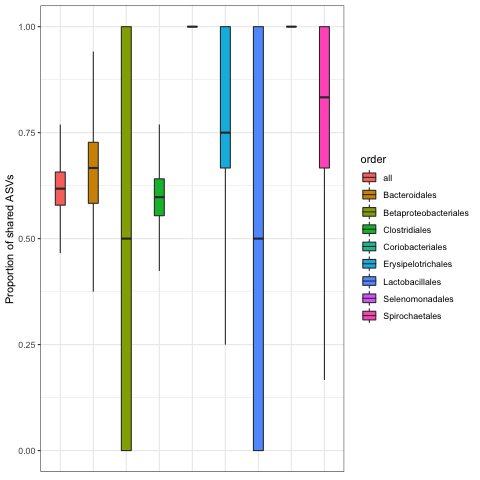

In [49]:
%%R
table_file <- paste0(OUTDIR,'/intermediate_output/16S_captive_Figure1C_data.txt')
Figure1C_data_all = read.table(table_file,header=TRUE,sep='\t')
Figure1C_data <- Figure1C_data_all %>% filter(sp_site_comp=='diff_spec_diff_site') 
Figure1C_plot <- ggplot(Figure1C_data, aes(x=order, y=prop_shared,fill=order)) + 
    geom_boxplot(width = 0.3,
                 position = position_dodge(width = 1),
                 outlier.shape = NA)+
    theme_bw()+
    ylab('Proportion of shared ASVs')+
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())
ggsave(Figure1C_plot, 
       file = file.path(paste0(OUTDIR,'/figures/Fig_propsharedASVs_by_order.pdf')))
print(Figure1C_plot)

#stats
alldf <- Figure1C_data_all %>% filter(sp_site_comp=='diff_spec_diff_site' & order=='all') 
pvalues <- c()
orders <- unique(Figure1C_data$order)
orders <- orders[2:length(orders)]
for (x in orders) {
  print(x)
  orderdf <- Figure1C_data %>% filter(sp_site_comp=='diff_spec_diff_site' & order==x) 
  print(nrow(orderdf))
  permtest <- (perm.t.test(alldf$prop_shared,orderdf$prop_shared))
  print(permtest)
  pvalues <- c(pvalues,permtest$p.value)
}
names(pvalues) <- orders
print(round(p.adjust(pvalues,method = "fdr",n = length(pvalues)),3))

#### sup figure proportion ASVs shared in Bacteroidales 

In [97]:
%%R
Bacteroidales_data <- Figure1C_data_all %>% filter(order=='Bacteroidales')
Bacteroidales_plot <- ggplot(Bacteroidales_data, aes(x=sp_site_comp, y=prop_shared,fill=sp_site_comp)) + 
    geom_violin()+
    theme_bw()+
    scale_fill_manual(values=c('#7fc97f','#beaed4','#fdc086','#ffff99'))+
    ylab('Proportion of shared ASVs')
ggsave(Bacteroidales_plot, 
       file = file.path(paste0(OUTDIR,'/figures/Fig_propsharedASVs_Bacteroidales.pdf')))
#stats
diff_spec_diff_site <- Bacteroidales_data$prop_shared[Bacteroidales_data$sp_site_comp=='diff_spec_diff_site']
diff_spec_same_site <- Bacteroidales_data$prop_shared[Bacteroidales_data$sp_site_comp=='diff_spec_same_site']
same_spec_diff_site <- Bacteroidales_data$prop_shared[Bacteroidales_data$sp_site_comp=='same_spec_diff_site']
site_comp <- perm.t.test(diff_spec_same_site,diff_spec_diff_site)
spec_comp <- perm.t.test(same_spec_diff_site,diff_spec_diff_site)
pval <- c(site_comp$p.value,spec_comp$p.value)
names(pval) <- c('site_comp','spec_comp')
print(round(p.adjust(pval,method = "fdr",n = length(pval)),3))

R[write to console]: Saving 6.67 x 6.67 in image



  |======================================================================| 100%
  |======================================================================| 100%
site_comp spec_comp 
    0.004     0.664 


#### sup figure proportion ASVs shared in Prevotella

In [68]:
pw_df = pw_metadata_capt_samples(metadata_file)
asv_table_tax = add_tax_to_asv_table(asv_table_file,tax_table_file)
Prevotella_genera = ['Prevotella','Prevotella_2','Prevotella_7','Prevotella_1', 'Prevotella_9']
asv_table_Prevotella = asv_table_tax[asv_table_tax['Genus'].isin(Prevotella_genera)]
shared_ASV_Prevotella = pw_df.apply(lambda row: 
    shared_ASVs_common_gen(row['ind1'],row['ind2'],asv_table_Prevotella),axis=1)
pw_shared_ASV_Prevotella = pw_df.merge(shared_ASV_Prevotella,on=['ind1','ind2']) 
pw_shared_ASV_Prevotella.to_csv(
    f'{OUTDIR}/intermediate_output/16S_captive_Prevotella_data.txt',
    sep='\t',index=False)

In [69]:
%%R
table_file <- paste0(OUTDIR,'/intermediate_output/16S_captive_Prevotella_data.txt')
Prevotella_data = read.table(table_file,header=TRUE,sep='\t')
Prevotella_plot <- ggplot(Prevotella_data, aes(x=sp_site_comp, y=prop_shared,fill=sp_site_comp)) + 
    geom_violin()+
    theme_bw()+
    scale_fill_manual(values=c('#7fc97f','#beaed4','#fdc086','#ffff99'))+
    ylab('Proportion of shared ASVs')
ggsave(Prevotella_plot, 
       file = file.path(paste0(OUTDIR,'/figures/Fig_propsharedASVs_Prevotella.pdf')))
#stats
diff_spec_diff_site <- Prevotella_data$prop_shared[Prevotella_data$sp_site_comp=='diff_spec_diff_site']
diff_spec_same_site <- Prevotella_data$prop_shared[Prevotella_data$sp_site_comp=='diff_spec_same_site']
same_spec_diff_site <- Prevotella_data$prop_shared[Prevotella_data$sp_site_comp=='same_spec_diff_site']
site_comp <- perm.t.test(diff_spec_same_site,diff_spec_diff_site)
spec_comp <- perm.t.test(same_spec_diff_site,diff_spec_diff_site)
pval <- c(site_comp$p.value,spec_comp$p.value)
names(pval) <- c('site_comp','spec_comp')
print(round(p.adjust(pval,method = "fdr",n = length(pval)),3))



R[write to console]: Saving 6.67 x 6.67 in image



  |======================================================================| 100%
  |======================================================================| 100%
site_comp spec_comp 
    0.276     0.012 


In [102]:
%%R
Fig_propsharedASVs_BactPrev <- plot_grid(Bacteroidales_plot, Prevotella_plot, nrow = 1,labels = "AUTO")
ggsave(Fig_propsharedASVs_BactPrev,
       width=12,height=5,
       file = file.path(paste0(OUTDIR,'figures/Fig_propsharedASVs_BactPrev.pdf')))

### Table 1

In [103]:
def output_summary_table(asv_hr_table_output):
     #create summary table
    all_asvs = pd.Series(asv_hr_table_output['HR_type'].value_counts(),name='ALL')
    cp_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['CP_pres']==True]['HR_type'].value_counts(),name='CP')
    Bacteroidales_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Order']=='Bacteroidales']['HR_type'].value_counts(),name='Bacteroidales')
    Bacteroides_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Genus']=='Bacteroides']['HR_type'].value_counts(),name='Bacteroides')
    Prevotella_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Genus'].isin(Prevotella_genera)]['HR_type'].value_counts(),name='Prevotella')
    Parabacteroides_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Genus']=='Parabacteroides']['HR_type'].value_counts(),name='Parabacteroides')
    Bifidobacteriales_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Order']=='Bifidobacteriales']['HR_type'].value_counts(),name='Bifidobacteriales')
    Bifidobacterium_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Genus']=='Bifidobacterium']['HR_type'].value_counts(),name='Bifidobacterium')
    res = pd.concat([all_asvs,cp_asvs,Bacteroidales_asvs,
                     Bacteroides_asvs,Prevotella_asvs,Parabacteroides_asvs,
                     Bifidobacteriales_asvs,Bifidobacterium_asvs],axis=1).fillna(0).T
    res = res[['HR_human','HR_wild_bonobo','HR_wild_chimp','HR_wild_gorilla',
         'MX_2_wild_apes','MX_3_wild_apes',
         'MX_human_single_wild_ape','MX_human_2_wild_apes',
         'MX_4_hominids','Unique_CP']]
    return(res)

In [108]:
asv_16s_summary = output_summary_table(asv_16s)
asv_16s_summary['MX_total'] = asv_16s_summary.loc[:,'MX_2_wild_apes':'MX_4_hominids'].sum(axis=1)
Table1 = asv_16s_summary[['HR_human','HR_wild_bonobo','HR_wild_chimp','HR_wild_gorilla',
                         'MX_total','Unique_CP']]
Table1.to_csv(f'{OUTDIR}/tables/Table1_16SASV_HRtype.txt',
    sep='\t',index=False)
print(Table1)

                   HR_human  HR_wild_bonobo  HR_wild_chimp  HR_wild_gorilla  \
ALL                   553.0            57.0          105.0            210.0   
CP                    227.0             0.0           10.0              8.0   
Bacteroidales         211.0            22.0           50.0             34.0   
Bacteroides            33.0             0.0            0.0              0.0   
Prevotella             63.0             5.0           15.0              8.0   
Parabacteroides         6.0             1.0            0.0              0.0   
Bifidobacteriales       3.0             0.0            0.0              0.0   
Bifidobacterium         3.0             0.0            0.0              0.0   

                   MX_total  Unique_CP  
ALL                   946.0      106.0  
CP                    520.0      106.0  
Bacteroidales          88.0       29.0  
Bacteroides            16.0        0.0  
Prevotella             16.0        4.0  
Parabacteroides         9.0        0.0  
B

In [105]:
print('Host_restricted ASVs')
print(asv_16s_summary.loc['ALL':'CP','HR_human':'HR_wild_gorilla'].sum(axis=1))
print('Mixed-host ASVs')
print(asv_16s_summary.loc['ALL':'CP':,'MX_2_wild_apes':'MX_4_hominids'].sum(axis=1))
print('Mixed-host ASVs found only in wild ape species')
print(asv_16s_summary.loc['ALL':'CP':,'MX_2_wild_apes':'MX_3_wild_apes'].sum(axis=1))
print('Mixed-host ASVs found only in wild apes and humans')
print(asv_16s_summary.loc['ALL':'CP':,'MX_human_single_wild_ape':'MX_4_hominids'].sum(axis=1))
print('proportion of MX_human_single_wild_ape ASVs found in captive apes')
print(asv_16s_summary.loc['CP','MX_human_single_wild_ape']/asv_16s_summary.loc['ALL','MX_human_single_wild_ape'])
print('proportion of MX_human_2_wild_apes ASVs found in captive apes')
print(asv_16s_summary.loc['CP','MX_human_2_wild_apes']/asv_16s_summary.loc['ALL','MX_human_2_wild_apes'])
print('proportion of MX_4_hominids ASVs found in captive apes')
print(asv_16s_summary.loc['CP','MX_4_hominids']/asv_16s_summary.loc['ALL','MX_4_hominids'])


Host_restricted ASVs
ALL    925.0
CP     245.0
dtype: float64
Mixed-host ASVs
ALL    946.0
CP     520.0
dtype: float64
Mixed-host ASVs found only in wild ape species
ALL    331.0
CP      39.0
dtype: float64
Mixed-host ASVs found only in wild apes and humans
ALL    615.0
CP     481.0
dtype: float64
proportion of MX_human_single_wild_ape ASVs found in captive apes
0.6951672862453532
proportion of MX_human_2_wild_apes ASVs found in captive apes
0.8152866242038217
proportion of MX_4_hominids ASVs found in captive apes
0.8783068783068783
